In [96]:
# imports
import pandas as p
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt


# constants
FOLDER_PATH = "../dataset/2019/"
FILE_NAME = 'cleaned_2019_01-02.csv'
SPEED_THRESHOLD = 0.3 # nautical knots
KNOTS_CONST = 1.943845249221964 # constant used to convert from m/s to nautical knots
EARTH_RADIUS_KM = 6378.137 # average value, used by geopy https://github.com/geopy/geopy/blob/master/geopy/distance.py
EARTH_RADIUS_M = 6378137

Import source csv into a dataframe

In [97]:
clean_df = p.read_csv(FOLDER_PATH + FILE_NAME)

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [98]:
def haversine_vectorized(lat_left, lon_left, lat_right, lon_right):
    '''Function used to calculate the Great-Circle distance between two GPS coordinates'''    
    lon_left, lat_left, lon_right, lat_right = map(np.radians, [lon_left, lat_left, lon_right, lat_right])
    deg_lon = lon_right - lon_left
    deg_lat = lat_right - lat_left
    a = np.sin(deg_lat/2.0)**2 + np.cos(lat_left) * np.cos(lat_right) * np.sin(deg_lon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = EARTH_RADIUS_M * c
    return meters

V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

# From the complete db, select only the necessary columns
clean_df = clean_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'COG', 'SOG']].copy()
# Drop duplicates, just in case
clean_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)

# for each ship
for mmsi in p.unique(clean_df['MMSI']):
    # Extract all points generated by the ship
    appendDF = p.DataFrame(clean_df[clean_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = np.nan
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['Status'] = np.nan
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points.
    # for the distance, the great-circle distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the roght one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    # add a new column that holds the time difference between the two point of the row
    pairsOfPointsDF['DeltaTime'] = p.to_datetime(pairsOfPointsDF['BaseDateTime_right']) - p.to_datetime(pairsOfPointsDF['BaseDateTime_left'])
    # add a new column that hold the distance (in meters) between the two points of the same row
    pairsOfPointsDF['Distance'] = haversine_vectorized(pairsOfPointsDF['LAT_left'],
                                                        pairsOfPointsDF['LON_left'],
                                                        pairsOfPointsDF['LAT_right'],
                                                        pairsOfPointsDF['LON_right']
                                                        )
    # calculate average speed (in m/s)
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Distance'] / pairsOfPointsDF['DeltaTime'].dt.total_seconds()
    # convert it into nautical knots
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'] * KNOTS_CONST
    # round the final value to 2 decimal digits
    pairsOfPointsDF['Speed'] = pairsOfPointsDF['Speed'].round(decimals=2)
    
    # save the speed values to the ship df
    appendDF['Avg_Speed'] = pairsOfPointsDF['Speed'].copy()
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # drop the first column (generated during all the processing above)
    appendDF.drop('index', axis=1, inplace=True)
    # save the dataframe to the vessels list
    V_s.append(appendDF)

print(V_s[-1])

           MMSI         BaseDateTime       LAT        LON    COG  SOG  \
0     229719000  2019-02-26 21:48:51  20.46748 -159.32628   86.0  9.6   
1     229719000  2019-02-26 22:05:50  20.48512 -159.28359   62.3  9.4   
2     229719000  2019-02-26 22:08:10  20.48795 -159.27778   63.8  9.4   
3     229719000  2019-02-26 22:09:50  20.49006 -159.27373   59.3  9.3   
4     229719000  2019-02-26 22:11:59  20.49282 -159.26860   61.6  9.3   
...         ...                  ...       ...        ...    ...  ...   
1145  229719000  2019-02-28 23:49:47  21.24124 -158.06926  317.6  2.7   
1146  229719000  2019-02-28 23:50:57  21.24189 -158.06988  316.6  2.6   
1147  229719000  2019-02-28 23:53:58  21.24335 -158.07133  321.5  2.2   
1148  229719000  2019-02-28 23:56:59  21.24479 -158.07208  345.5  1.6   
1149  229719000  2019-02-28 23:59:57  21.24597 -158.07219    8.5  1.5   

      Avg_Speed  Status  
0          9.60     NaN  
1          9.28     NaN  
2          9.48     NaN  
3          9.39    

Next part of the TREAD algorithm</br>

Consider as stationary all points where the estimated average speed is lower then a set threshold</br>
Consider the first (entry) and last (exit) recorded points of each ship as 'stationary', regardless of the estimated speed.</br>
Set all remaing points as 'sailing'</br>

            MMSI         BaseDateTime       LAT        LON    COG  SOG  \
10640  338070127  2019-01-24 14:18:23  21.31309 -157.86718    0.0  0.0   
10641  338070127  2019-01-24 14:21:23  21.31310 -157.86716    0.0  0.0   
10642  338070127  2019-01-24 14:24:24  21.31310 -157.86717    0.0  0.0   
10643  338070127  2019-01-24 14:27:23  21.31309 -157.86714  142.5  0.9   
10644  338070127  2019-01-24 14:28:24  21.31215 -157.86705  174.5  8.2   
...          ...                  ...       ...        ...    ...  ...   
10780  338070127  2019-01-24 19:36:17  21.31311 -157.86716  141.1  0.0   
10781  338070127  2019-01-24 19:39:47  21.31312 -157.86716    1.4  0.0   
10782  338070127  2019-01-24 19:42:45  21.31312 -157.86716    0.0  0.0   
10783  338070127  2019-01-24 19:45:47  21.31312 -157.86717    0.0  0.0   
10784  338070127  2019-01-24 19:51:46  21.31312 -157.86715   31.7  0.0   

       Avg_Speed      Status  
10640       0.01  stationary  
10641       0.03  stationary  
10642       0.01  

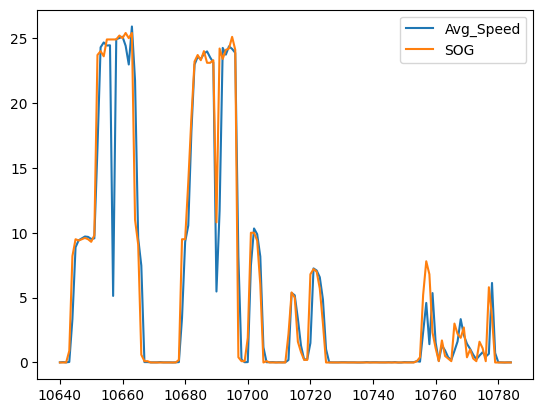

In [99]:
# for each vessel (dataframe) in the V_s list,

for shipDF in V_s:
    # set the status of each point where the avg_speed is lower than the given threshold, to 'stationary'
    shipDF['Status'] = np.where(shipDF["Avg_Speed"] < SPEED_THRESHOLD, 'stationary', shipDF['Status'])
    # set all remaining points as "sailing"
    shipDF['Status'] = np.where(shipDF["Avg_Speed"] >= SPEED_THRESHOLD, 'sailing', shipDF['Status'])
    # set the first (entry points) and last points of the ship (exit points) as stationary, regardless of speed (see algorithm)
    shipDF.at[shipDF.index[0], 'Status'] = 'stationary'
    shipDF.at[shipDF.index[-1], 'Status'] = 'stationary'
    
# print a dataframe and some points just to check
interval = range(10640,10785)
print(V_s[3].iloc[interval])
plt.plot(V_s[3]['Avg_Speed'].iloc[interval])
plt.plot(V_s[3]['SOG'].iloc[interval])
plt.legend(['Avg_Speed', 'SOG'])


In [100]:
# Extract all the stationary points in a single dataframe

stationaryDF = p.DataFrame(columns=['LAT', 'LON']) # new empty df

for vesselDF in V_s:
    extractedDF = vesselDF[vesselDF['Status'] == 'stationary']
    stationaryDF = p.concat([stationaryDF, extractedDF[['LAT', 'LON']]], ignore_index=True)

print(stationaryDF)
print(stationaryDF.shape)

/tmp/ipykernel_25428/2279343906.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



              LAT        LON
0        21.31309 -157.86712
1        21.31309 -157.86712
2        21.31309 -157.86712
3        21.31309 -157.86712
4        21.31308 -157.86712
...           ...        ...
2529975  21.26726 -158.08703
2529976  21.26728 -158.08701
2529977  21.26740 -158.08696
2529978  21.26733 -158.08692
2529979  21.24597 -158.07219

[2529980 rows x 2 columns]
(2529980, 2)


In [101]:
# Some computationl tricks in order to save some time

# Round lat and lon values to 4 decimal digits (instead of 5)
stationaryDF = stationaryDF.round(decimals=4)
# Group-by same (lat,lon) pairs and count occurrencies
groupedDF = stationaryDF.groupby(['LAT', 'LON']).size().reset_index(name='Weight')

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

# Apply log2() (base-2 logarithm) to the 'weight' column in order to rescale its values
groupedDF['Weight'] = np.round(
                                np.log2(groupedDF['Weight']),
                                decimals=0
                            )
# The minimum weight should be 1, so any zero is replaced
groupedDF['Weight'].replace(0,1,inplace=True)

print(groupedDF)

print("Pair with most occurrencies: \n" + str(groupedDF.iloc[groupedDF['Weight'].idxmax(), :]) + '\n')

Pair with most occurrencies: 
LAT          21.2970
LON        -158.1065
Weight    39186.0000
Name: 19051, dtype: float64

           LAT       LON  Weight
0      18.7671 -159.1110     1.0
1      18.7671 -157.4313     1.0
2      18.7673 -155.9327     1.0
3      18.7677 -155.7892     1.0
4      18.7680 -158.2825     1.0
...        ...       ...     ...
27658  22.6305 -158.4078     1.0
27659  22.6305 -155.6834     1.0
27660  22.6306 -156.1920     1.0
27661  22.6307 -156.9234     1.0
27662  22.6308 -156.8662     1.0

[27663 rows x 3 columns]
Pair with most occurrencies: 
LAT        21.2970
LON      -158.1065
Weight     15.0000
Name: 19051, dtype: float64



/tmp/ipykernel_25428/2760693775.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





DBSCAN(eps=0.02, min_samples=40) len: 27663, num of clusters: 54
           LAT       LON  Weight  Label
0      18.7671 -159.1110     1.0     -1
1      18.7671 -157.4313     1.0     -1
2      18.7673 -155.9327     1.0     -1
3      18.7677 -155.7892     1.0     -1
4      18.7680 -158.2825     1.0     -1
...        ...       ...     ...    ...
27658  22.6305 -158.4078     1.0     -1
27659  22.6305 -155.6834     1.0     -1
27660  22.6306 -156.1920     1.0     -1
27661  22.6307 -156.9234     1.0     -1
27662  22.6308 -156.8662     1.0     -1

[27663 rows x 4 columns]


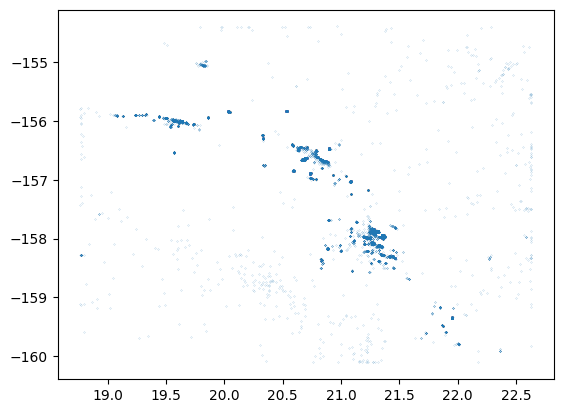

In [102]:
# Run DBSCAN algorithm on the stationary points

# this scatter plot gives a rough idea of how the point should look like plotted on a map
plt.scatter(groupedDF.iloc[:,0], groupedDF.iloc[:,1], s=0.01)

# inizitalize dbscan object with parameters. TODO: test multiple parameters combinations
dbscan = DBSCAN(eps=0.020, min_samples=40)

estimator = dbscan.fit(
                    X=groupedDF.iloc[:, :2], 
                    sample_weight=groupedDF['Weight']
                    )


print(str(estimator) + " len: " + str(len(estimator.labels_)) + ", num of clusters: " + str(max(estimator.labels_)))

# Add labels to the dataframe
groupedDF['Label'] = estimator.labels_

print(groupedDF)

In [103]:
# plot the result of the DBSCAN clustering on a map (to have a look at the effects of the parameters)
import plotly.express as px
import plotly.offline as po

clusteredPointsDF = groupedDF[groupedDF['Label'] != -1].copy()

outliersDF = groupedDF[groupedDF['Label'] == -1].copy()


fig = px.scatter_mapbox(data_frame = clusteredPointsDF,
                        lon = clusteredPointsDF['LON'],
                        lat= clusteredPointsDF['LAT'],
                        zoom = 5,
                        color = clusteredPointsDF['Label'],
                        title = 'Clustered stationary points',
                        color_continuous_scale='portland'
                        )

fig.add_scattermapbox(
                      lat= outliersDF['LAT'],
                      lon= outliersDF['LON'],
                      below=0,
                      marker={'color':'white'}
                      )

fig.update_layout(mapbox_style = 'open-street-map')

po.plot(fig)


'temp-plot.html'